# Introduction to Probabilistic Graphical Models
## Mini Project
### Author: Xiang Yu, Email: shawnxiangyu@yahoo.com

In [10]:
%matplotlib inline
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx
import pyparsing
from IPython.display import Math
import copy
import math
from matplotlib.patches import Ellipse 
import scipy.io as sio
from numba import njit
from matplotlib import gridspec
from tqdm import tqdm
from numba import jit
import time


# choose a large font size by default and use tex for math
fontsize = 10
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize}
plt.rcParams.update(params)

#### Question 1.1 : Draw the directed graphical model

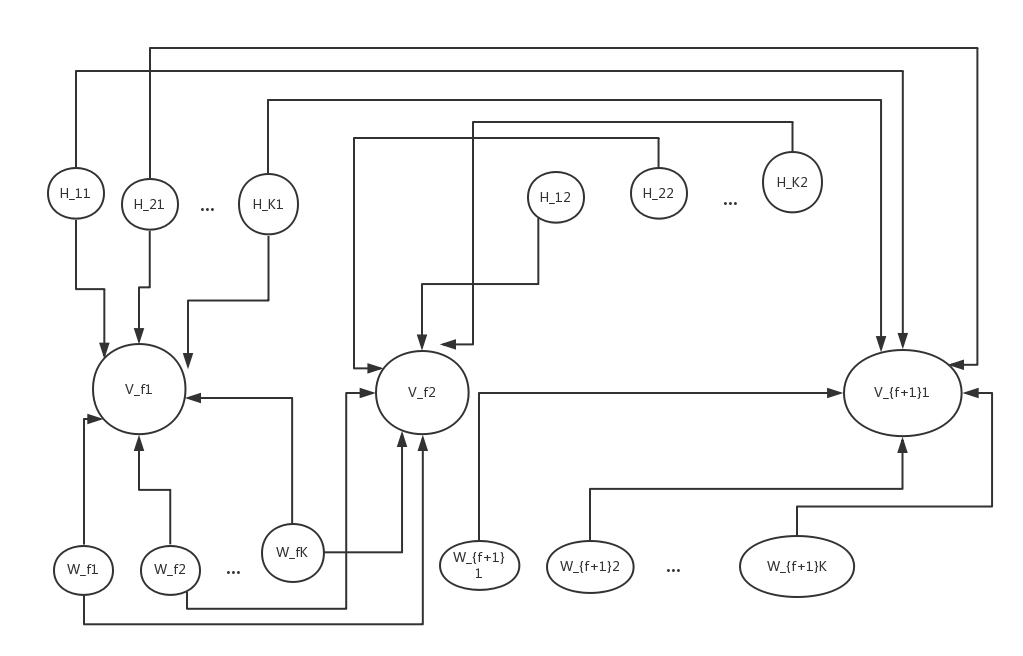

In [11]:
# Draw the directed graphical model: without S
from IPython.display import Image
Image("graph_noS.jpg")

The above directed graph is When S is not introduced. We only draw three elements of V, for the rest, the same pricipal applies. The  node represented by $...$ should follow the same pricipal as other nodes nearby.

When S is introduced, the graph will be as follows: 


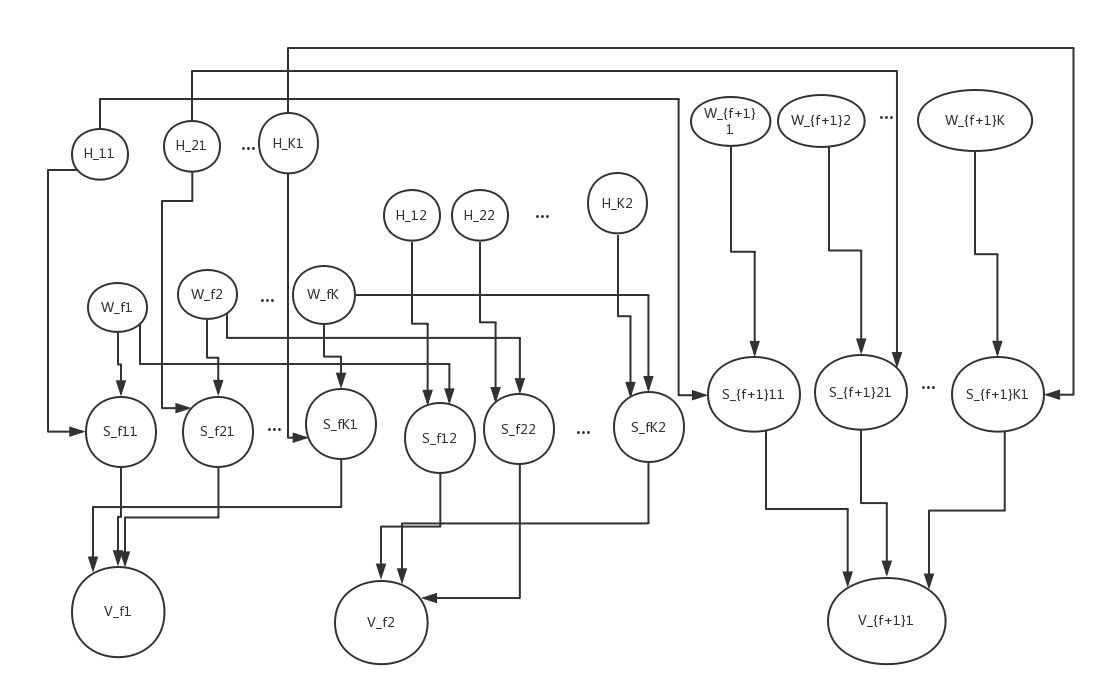

In [12]:
### Draw the directed graphical model: with S introduced
Image("graphWithS.jpg")

We only draw three elements of V, for the rest, the same pricipal applies. The node represented by $...$ should follow the same pricipal as other nodes nearby.

### Question 1.2 Derive the EM algorithm for NMF

Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. (source: wiki)

NMF is used for feature extraction and is generally seen to be useful when there are many attributes, particularly when the attributes are ambiguous or are not strong predictors. By combining attributes NMF can display patterns, topics, or themes which have importance. NMF method is found in many applications, for this project, our goal is to obtain a ‘parts-based-representation’ of faces by learning an NMF model on AT&T Database of Facesdataset. Our hope is that, when we estimate the matrices W and H by using V, the columns of W will correspond to some images that only contain a particular part of a face. 

#### Goal: Find $W, H$ such that for a given $V$, $ V \approx W H$
Given an $F \times N$ matrix $V$ with nonnegative elements, we wish to
find nonnegative, rank-$K$ matrices $W$ ($F \times K$) and $H$ ($K
\times N$) such that $$ V \approx W H $$

or more precisely: 
$$ V_{fn} \approx \sum_{k = 1}^{K} W_{fk} H_{kn}$$

The goal can be achieved by solving the maximum a-posteriori estimate (MAP) problem, an optimization problem: 
$$ (W, H) \in  arg \max_{W,\  H \geq 0} P(W, H|V) $$ 

The approximation between $WH$ and $V$ could be measured by Kullback–Leibler(KL) divergence

#### E-step 1: E function overview

In the following calculation, when no confusion occurs, we use $Z$ to denote the parameters $(W, H)$,i.e. $Z = (W, H)$, and assuming the independce between $W, H$, we have $P(Z) = P(W, H) = P(W)P(H)$, then 

$$ P(W, H|V) = P(Z|V) = P(V,Z)P(V) $$

We could solve the optimization problem with Expectation–maximization(EM) algorithm taught during the lecture.

Here we introduce a latent variable $S$ with the following properties: 

$$q(S) > 0,\  \sum_S q(S) = 1 $$

Then the original optimization problem will be equivilant to 
\begin{align}
arg \max_{W,\  H \geq 0} P(W, H|V)  
& \propto  arg \max_{Z \geq 0} P(Z|V) \\
& \propto  arg \max_{Z \geq 0} \log P(Z|V) \\
& \propto  arg \max_{Z \geq 0} \log (P(V, Z)P(V)) \\ 
& \propto  arg \max_{Z \geq 0} \log P(V, Z)
\end{align}


And 
\begin{align}
\log P(V, Z)
&=  \log \sum_S P(V, S, Z) \\
& = \log \sum_S P(V, S, Z) \frac{q(S)}{q(S)} \\
& = \log \sum_S \frac{P(V, S, Z)}{q(S)} q(S) \\
& = \log \mathbb{E}[\frac{P(V, S, Z)}{q(S)}]_{q(S)} \\
& \geq \mathbb{E} \log [\frac{P(V, S, Z)}{q(S)}]_{q(S)}
\end{align}

We have proved during the lecture for EM algorithm that: 

$$ q(S) = P(S|V, Z)$$


Then we have 
\begin{align}
\log P(V, Z) \geq \mathbb{E} \log [\frac{P(V, S, Z)}{q(S)}]_{q(S)} 
&  = \sum q(S) \log \frac{P(V, S, Z)}{q(S)} \\
&  = \sum q(S) \log {P(V, S, Z)} - \sum q(S) \log q(S) \\
&  = \mathbb{E} [\log P(V, S, Z)]_{q(S)} - \mathbb{E} [\log q(S)]_{q(S)} \\
&  = \mathbb{E} [\log P(V, S, Z)]_{P(S|V, Z^{t})} - \mathbb{E} [\log P(S|V, Z^{t})]_{P(S|V, Z^{t})}
\end{align} 

We need to maximize the right side of above equaiton with respect to the parameter $Z = (W, H)$, given $Z^t$.
Then,

$$
arg \max_{Z \geq 0} \mathbb{E} [\log P(V, S, Z)]_{P(S| V, Z^{t})} - \mathbb{E} [\log P(S|V, Z^{t})]_{P(S|V, Z^{t})}  \propto arg \max_{Z \geq 0} \mathbb{E} [\log P(V, S, Z)]_{P(S|V, Z^{t})}
$$

Then we have the E-step function to be maximized as follows: 
$$L(Z) = \mathbb{E} [\log P(V, S, Z)]_{P(S|V, Z^{t})}$$

In order to calculate $L(Z)$, we should calculate the terms in $L(Z)$ first. I.e. the following two terms: 
-  $P(S|V, Z^{t})$
- $\log P(V, S, Z)$

#### E-step 2: term $P(S|V, Z^{t})$

We have: 
$$P(S|V, Z^{t}) = \frac{P(S, V, Z^{t})}{P(V, Z^{t})} = \frac{P(S, V|Z^{t})}{P(V|Z^{t})}$$

And according to the directed graph model in Question 1.1, we have: 

$$P(S, V|Z^{t}) = P(V|S)P(S|Z^{t})$$

Therefore, we have: 
$$P(S|V, Z^{t}) = \frac{P(V|S)P(S|Z^{t})}{P(V|Z^{t})}$$


Notice: the $S$ is introduced to have the following properties: 

$$V_{fn} = \sum_{k = 1}^{K} S_{f\_k\_n}, \  S_{f\_k\_n} \sim \operatorname{Poisson}(S_{f\_k\_n}; W_{fk} H_{kn}) $$

When no confusion occurs, we write: 
$$S_{f\_k\_n}: = S_k, \ and \  W_{fk} H_{kn}: = Z_{f\_k\_n}$$




Thus: 

$$V_{fn} = \sum_{k = 1}^{K} S_k, \  S_k\sim \operatorname{Poisson}(S_k; Z_{f\_k\_n}) $$

From Poission distribution we know that for any $a, b$, we have: 
$$\operatorname{Poisson}(a; b) = P(a|b) = \exp (a \log b - b - \log \Gamma (a + 1)) $$

Then: 
$$P(S_k|Z_k^{t}) = \operatorname{Poisson}(S_k; W_{fk}^tH_{kn}^t) = \operatorname{Poisson}(S_k; Z_{f\_k\_n}^t) = \exp (S_k \log Z_{f\_k\_n}^t - Z_{f\_k\_n}^t - \log \Gamma (S_k + 1))  $$

With $V_{fn} = \sum_{k = 1}^{K} S_k$ and $S_k\sim \operatorname{Poisson}(S_k; Z_{f\_k\_n}) $, and according to the well-know superposition property of Poisson random variables. we have: 


$$P(V_{fn}|Z^{t}) \sim \operatorname{Poisson}(V_{fn}; \sum_{k = 1}^{K}  Z_{f\_k\_n}^t)$$

We also have: 
$$P(V_{fn}|S) = P(V_{fn}|S_{1:K}) = \delta (V_{fn}- \sum_{k = 1}^{K} S_k)$$
where: 
$$
\delta(x) = \{
\begin{array}{ll}
  1, \ if \ x = 0 \\
  0, \ otherwise
\end{array}
$$

With the given information and the lecture notes, we know that $P(S_{1:K}|V_{fn})$ follows a multinomial distribution, with 

$$P(S_{1:K}|V_{fn}) =\delta (V_{fn}- \sum_{k = 1}^{K} S_k) \frac{V_{fn}!}{S_1!S_2!...S_K!}(\frac{Z_{f\_1\_n}}{\sum_k Z_{f\_k\_n}})^{S_1}...(\frac{Z_{f\_K\_n}}{\sum_k Z_{f\_k\_n}})^{S_K}$$

Then: 
$$\log P(S|V, Z^{t}) = \log \frac{P(V|S)P(S|Z^{t})}{P(V|Z^{t})} = \log P(V|S)P(S|Z^{t}) - \log P(V|Z^{t}) $$

Where 
\begin{align}
\log P(V|Z^{t})
& = \log \Pi_{f,\  n} \operatorname{Poisson}(V_{fn}; \sum_{k = 1}^{K}  Z_{f\_k\_n}^t) \\
& = \sum_{f,\  n} \log \operatorname{Poisson}(V_{fn}; \sum_{k = 1}^{K}  Z_{f\_k\_n}^t) \\
&= \sum_{f,\  n} (V_{fn} \log \sum_k Z_{f\_k\_n}^t - \sum_k Z_{f\_k\_n}^t - \log \Gamma (V_{fn} + 1)) 
\end{align}

and 
\begin{align}
\log P(V|S)P(S|Z^{t})
& = \log \Pi_{f,\  n} [P(V_{fn}|S_{1:K}) \Pi_{k = 1}^{K} P(S_k|Z_{f\_k\_n}^t)] \\
& = \sum_{f,\  n} [\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) + \sum_{k = 1}^{K} \log \operatorname{Poisson}(S_k; Z_{f\_k\_n}^t)] \\
&= \sum_{f,\  n} [\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) + \sum_{k = 1}^{K} (S_k \log Z_{f\_k\_n}^t - Z_{f\_k\_n}^t - \log \Gamma (S_k + 1))]
\end{align}




#### E-step 3: term $\log P(V, S, Z)$

We have: 

$$ P(V, S, Z) = P(V|S, Z)P(S, Z) = P(V|S)P(S|Z)P(Z) = P(V|S)P(S|WH)P(W, H) = P(V|S)P(S|WH)P(W)P(H) $$


For $W$ and $H$, we assume them to follow Gamma distribution due to the computational convenience. 
I.e. we have: 

$$W_{fk} \sim \gamma(W_{fk}; \alpha_w, \beta_w)$$
$$H_{kn} \sim \gamma(H_{kn}; \alpha_h, \beta_h)$$

Where $\alpha \geq 0$ is the shape parameter and $\beta$ the scale parameter, and 
$$ \gamma(x; \alpha, \beta) = \exp((\alpha - 1)\log x - \frac{x}{\beta} - \log \Gamma(\alpha) - \alpha\log \beta )$$


Then we have: 
\begin{align}
\log P(V, S, Z) 
& = \log P(V|S)P(S|WH)P(W)P(H)  \\
& = \log \Pi_{f,\  n} [P(V_{fn}|S_{1:K}) \Pi_{k = 1}^{K} P(S_k|Z_{f\_k\_n})P(W_{fk})P(H_{kn})] \\
& = \sum_{f,\  n} \{\log P(V_{fn}|S_{1:K}) \sum_{k = 1}^{K} [\log P(S_k|Z_{f\_k\_n}) + \log P(W_{fk}) + \log P(H_{kn})]\}\\
& = \sum_{f,\  n} [\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) + \sum_{k = 1}^{K} (\log \operatorname{Poisson}(S_k; Z_{f\_k\_n})  + \log P(W_{fk}) + \log P(H_{kn})) ] 
\end{align}


Then, 
\begin{align}
\log P(V, S, Z) 
&= \sum_{f,\  n} \{\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) \\
 & + \sum_{k = 1}^{K} [S_k \log Z_{f\_k\_n} - Z_{f\_k\_n} - \log \Gamma (S_k + 1) + \log \gamma(W_{fk}, \alpha_w, \beta_w) + \log \gamma(H_{kn}, \alpha_h, \beta_h)]\} 
 \end{align}
 
\begin{align} 
\log P(V, S, Z) 
&= \sum_{f,\  n} \{\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) + \sum_{k = 1}^{K} [S_k \log Z_{f\_k\_n} - Z_{f\_k\_n} - \log \Gamma (S_k + 1) \\
& \ \ \  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w} - \log \Gamma(\alpha_w) - \alpha_w \log \beta_w 
+ (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h} - \log \Gamma(\alpha_h) - \alpha_h \log \beta_h]\} 
 \end{align}

#### E-step 4: E-function in detail: 
We have the expectation function as follows: 
$$L(Z) = \mathbb{E} [\log P(V, S, Z)]_{P(S|V, Z^{t})}$$

Denote: $P(S|V, Z^{t}): = \gamma^t$, then: 
\begin{align}
\max_Z L(Z) 
& = \max_Z \mathbb{E} [\log P(V, S, Z)]_{\gamma^t} \\
& = \max_{W, H} \mathbb{E} [\log P(V|S)P(S|WH)P(W)P(H)]_{\gamma^t} \\
& = \max_{W, H}  \mathbb{E} \sum_{f,\  n} \{\log P(V_{fn}|S_{1:K}) \sum_{k = 1}^{K} [\log P(S_k|Z_{f\_k\_n}) + \log P(W_{fk}) + \log P(H_{kn})]\}_{\gamma^t} \\
&= \max_{W, H} \sum_{f,\  n} \{ \mathbb{E}[\log P(V_{fn}|S_{1:K})]_{\gamma^t} + \mathbb{E}[\sum_{k = 1}^{K}(\log P(S_k|Z_{f\_k\_n}) + \log P(W_{fk}) + \log P(H_{kn}))]_{\gamma^t} \} \\
&  \propto \max_{W, H}  \sum_{f,\  n} \mathbb{E}[\sum_{k = 1}^{K}(\log P(S_k|Z_{f\_k\_n}) + \log P(W_{fk}) + \log P(H_{kn}))]_{\gamma^t} \\
&= \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K} \mathbb{E}[\log P(S_k|Z_{f\_k\_n}) + \log P(W_{fk}) +  \log P(H_{kn})]_{\gamma^t} \\
&= \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K} \mathbb{E} \{S_k \log Z_{f\_k\_n} - Z_{f\_k\_n} - \log \Gamma (S_k + 1) \\
& \ \ \ + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w} - \log \Gamma(\alpha_w) - \alpha_w \log \beta_w +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h} - \log \Gamma(\alpha_h) - \alpha_h \log \beta_h \}_{\gamma^t} \\
&=  \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K}   \mathbb{E}\{S_k \log (W_{fk}H_{kn}) -  W_{fk}H_{kn} - \log \Gamma (S_k + 1) \\
& \ \ \ + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w} - \log \Gamma(\alpha_w) - \alpha_w \log \beta_w +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h} - \log \Gamma(\alpha_h) - \alpha_h \log \beta_h \}_{\gamma^t} \\
& \propto \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K}  \mathbb{E} \{S_k \log (W_{fk}H_{kn}) -  W_{fk}H_{kn}  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w}  +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h}\}_{\gamma^t}
\end{align}




We have $$ \gamma^t = P(S|V, Z^{t}) = \frac{P(S, V, Z^{t})}{P(V, Z^{t})}$$
and $$\sum_S \gamma^t = \sum_S \frac{P(S, V, Z^{t})}{P(V, Z^{t})} = 1 $$
Therefore: 
$$\mathbb{E} [Z]_{\gamma^t} = Z, \mathbb{E} [W]_{\gamma^t} = W, \mathbb{E} [H]_{\gamma^t} = H$$

We could further simplify the objective function: 
\begin{align}
\max_Z L(Z) 
& \propto \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K}  \mathbb{E} \{S_k \log (W_{fk}H_{kn}) -  W_{fk}H_{kn}  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w}  +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h}\}_{\gamma^t} \\
& = \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K}  \{\mathbb{E} [S_k \log (W_{fk}H_{kn})]_{\gamma^t}  -  W_{fk}H_{kn}  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w}  +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h} \}
\end{align}

For the term $\mathbb{E} [S_k \log (W_{fk}H_{kn})]_{\gamma^t}$, we could calcualate based on the distribution of $S_k$ and the value of $\gamma^t$. 

$$\mathbb{E} [S_k \log (W_{fk}H_{kn})]_{\gamma^t} = \log (W_{fk}H_{kn})\mathbb{E} [S_k]_{\gamma^t} $$
We have:

\begin{align}
\log \gamma^t 
& = \log P(S|V, Z^{t}) \\
& = \log P(V|S)P(S|Z^{t}) - \log P(V|Z^{t}) \\
& = \sum_{f,\  n} [\log \delta (V_{fn}- \sum_{k = 1}^{K} S_k) + \sum_{k = 1}^{K} (S_k \log Z_{f\_k\_n}^t - Z_{f\_k\_n}^t - \log \Gamma (S_k + 1))] - \sum_{f,\  n} (V_{fn} \log \sum_k Z_{f\_k\_n}^t - \sum_k Z_{f\_k\_n}^t - \log \Gamma (V_{fn} + 1)) 
\end{align}


We have 
$$V_{fn} = \sum_{k = 1}^{K} S_k, \  S_k = S_{f\_k\_n} \sim \operatorname{Poisson}(S_{f\_k\_n}; W_{fk} H_{kn}) $$
Therefore we could simplify the term with $\mathbb{E}[S_k]_{\gamma^t} $ here based on the properties of mutilnomial and Possion distribution:  
$$ \mathbb{E}[S_k]_{\gamma^t} = \mathbb{E}[S_{f\_k\_n}]_{\gamma^t} = V_{fn}P(S_{f\_k\_n}) = V_{fn} \frac{Z_{f\_k\_n}^t}{\sum_{k=1}^K Z_{f\_k\_n}^t} = V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t}$$

Then,
$$\mathbb{E} [S_k \log (W_{fk}H_{kn})]_{\gamma^t} = \log (W_{fk}H_{kn}) V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t}$$

Therefore
$$
\max_Z L(Z)  \propto \max_{W, H}  \sum_{f,\  n} \sum_{k = 1}^{K}  \{ \log (W_{fk}H_{kn}) V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t} -  W_{fk}H_{kn}  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w}  +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h} \}
$$


#### M-step: update W and H

We could update the objective function $L(Z)$ as $L(W, H) = \sum_{f,k,n}l(W_{fk}, H_{kn})$, where

$$l(W_{fk}, H_{kn}) = \log (W_{fk}H_{kn}) V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t} -  W_{fk}H_{kn}  + (\alpha_w - 1)\log W_{fk} - \frac{W_{fk}}{\beta_w}  +  (\alpha_h - 1)\log H_{kn} - \frac{H_{kn}}{\beta_h}$$

\begin{align}
\frac{\partial l}{\partial W_{fk}} 
& = \frac{1}{W_{fk}}V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t} - H_{kn} + \frac{\alpha_w - 1}{W_{fk}} - \frac{1}{\beta_w}\\
& =  \frac{\alpha_w - 1 + V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t}}{W_{fk}} - H_{kn}  - \frac{1}{\beta_w}
\end{align}

Then, 
\begin{align}
\frac{\partial L(W, H) }{\partial W_{fk}} 
& = \frac{\alpha_w - 1 + \sum_n (V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t})}{W_{fk}} -\sum_n H_{kn}  - \frac{1}{\beta_w} \overset{!}{=} 0
\end{align}

Therefore: 
$$ W_{fk}^{t+1} = \frac{\alpha_w - 1 + \sum_n (V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t}) }{\sum_n H_{kn}  + \frac{1}{\beta_w} }$$


Similarly, 
\begin{align}
\frac{\partial l}{\partial H_{kn}} 
& = \frac{1}{H_{kn}}V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t} - W_{fk} + \frac{\alpha_h - 1}{H_{kn}} - \frac{1}{\beta_h}\\
& =  \frac{\alpha_h - 1 + V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t}}{H_{kn}} - W_{fk}  - \frac{1}{\beta_h}
\end{align}

\begin{align}
\frac{\partial L(W, H)}{\partial H_{kn}} 
& = \frac{\alpha_h - 1 + \sum_f (V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t})}{H_{kn}} - \sum_f W_{fk}  - \frac{1}{\beta_h}  \overset{!}{=} 0
\end{align}


Therefore: 
$$ H_{kn}^{t+1} = \frac{ \alpha_h - 1 + \sum_f[V_{fn} \frac{W_{fk}^t H_{kn}^t}{\sum_{k=1}^K W_{fk}^t H_{kn}^t} ]}{\sum_f W_{fk} + \frac{1}{\beta_h}}$$


### Question 2

#### Question 2.1 Implementation of EM for NMF

##### load the input data

In [13]:
# read the raw data 
# please put the input data under the same folder
imgs_data = sio.loadmat('attfaces.mat')
V = imgs_data['V']

#####  EM method

In [14]:
# Kullback-Leibler divergence
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n: p: V, q: NewV
    Discrete probability distributions.
    """  
    eps = np.finfo(float).eps
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    p[p <=eps] = eps
    q[q <= eps] = eps 
    return - np.sum(p * np.log(q / p) - q + p)


def updateWH(nr_iter, Wt, Ht, para_wh, threshold=1e-8): 
    
    alpha_w = para_wh[0]
    beta_w = para_wh[1]
    alpha_h = para_wh[2]
    beta_h = para_wh[3]

    Diffs = np.zeros((nr_iter + 1,1))
  
    # Diffs[0] = kl(V,  Wt.dot(Ht)) # use KL divergence
    Diffs[0] = np.linalg.norm(V - Wt.dot(Ht)) # use Euclidean distance to measure the approximation
    max_iter = 500  
    for i in np.arange(nr_iter): 
        Wtp = np.divide(Wt * (V / Wt.dot(Ht)).dot(Ht.T) + (alpha_w - 1), np.sum(Ht , axis=1) + 1 / beta_w)
        Htp = np.divide((Wtp.T.dot(V / Wtp.dot(Ht)) * Ht + (alpha_h -1)).T, np.sum(Wtp , axis=0) + 1 / beta_h).T
        Wt = np.abs(Wtp.copy())  # enforce the non-negative properties
        Ht = np.abs(Htp.copy())

        #Diffs[i+1] = kl(V,  Wt.dot(Ht))
        Diffs[i+1] = np.linalg.norm(V - Wt.dot(Ht))
        if np.abs(Diffs[i+1] - Diffs[i]) / Diffs[i+1] < threshold or i > max_iter: 
            Diffs = Diffs[1:i+1]
            break      
    return Diffs, Wt, Ht  


In [15]:
# initialize the W, H from gamma distribution
def init_para(alpha, beta, size): 
    return np.random.gamma(alpha, beta, size)


def EM(para_wh, K=25, nr_iter=150, threshold=1e-8):

    # initialize one set of inputs for EM algorithm
    alpha_w = para_wh[0]
    beta_w = para_wh[1] 
    alpha_h = para_wh[2]
    beta_h = para_wh[3]

    W_init = init_para(alpha_w, beta_w, (F, K))
    H_init = init_para(alpha_h, beta_h, (K, N))
    Diffs, W, H = updateWH(nr_iter, W_init, H_init, para_wh, threshold)

    return Diffs, W, H

In [16]:
size = np.shape(V)
K = 25
F = size[0]
N = size[1]

In [17]:
# run EM algorithm with the intilized data
nr_iter = 300
para_wh = [1, 1, 1, 1]
Diffs, W, H = EM(para_wh, K, nr_iter, threshold=1e-8)

In [18]:
def plot_img(imgs, nr_rows, nr_cols, titlestr, grayscale=True): 
    
    fig = plt.figure(figsize = (15,15))    
    gs1 = gridspec.GridSpec(nr_rows, 1)
    gs1.update(wspace=0, hspace=0) # set the spacing between axes.
    cmap = 'None' if grayscale == False else 'gray'
    img_nr = 0 
    
    for rowi in np.arange(nr_rows):     
        img_ij = []
        
        for colj in np.arange(nr_cols):                  
            img_j = imgs[:,:,img_nr]
            if colj > 0: 
                img_ij = np.concatenate((img_ij, img_j))
            else: 
                img_ij = img_j
            img_nr += 1
        
        ax1 = plt.subplot(gs1[rowi])
        plt.axis('on')
        plt.imshow(img_ij.T, cmap=cmap)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.subplots_adjust(wspace=0, hspace=0) 

    fig.suptitle(titlestr)
    fig.subplots_adjust(top=0.95)
    plt.show()       
            

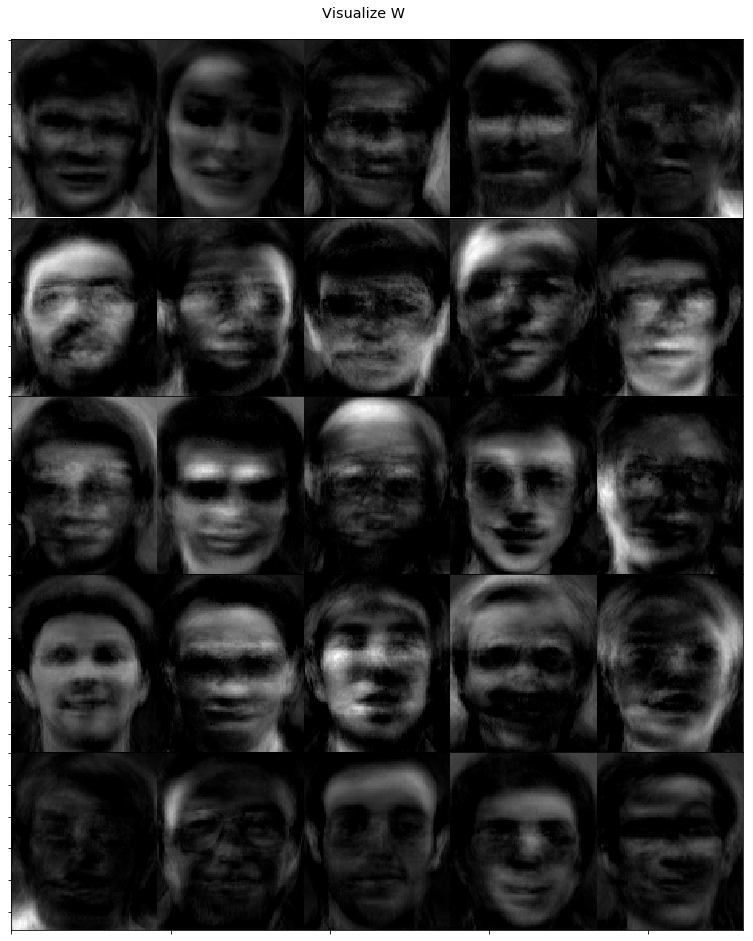

In [19]:
# plot W
W_imgs = W.reshape((92, 112, K))
plot_img(W_imgs, 5, 5, 'Visualize W')

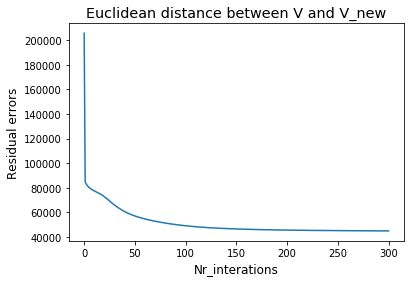

In [20]:
# plot the convergence graph
plt.plot(np.arange(len(Diffs)), Diffs)
plt.xlabel('Nr_interations')
plt.ylabel('Residual errors')
plt.title('Euclidean distance between V and V_new')
plt.show()

#### Iteration number set to 150
As shown from the above graphs, the model approximates a converged state after around 150 iterations, i.e. after around 150, the accruacy does not improve significantly. Then, we choose the number of iterations to be 150 as a compromise between speed and accuracy.

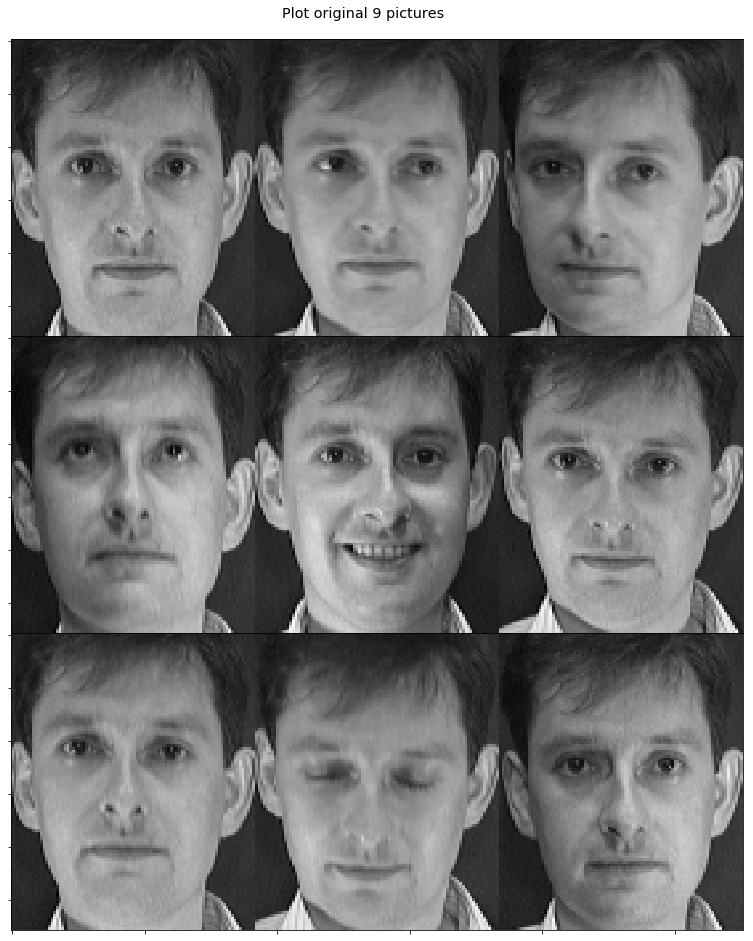

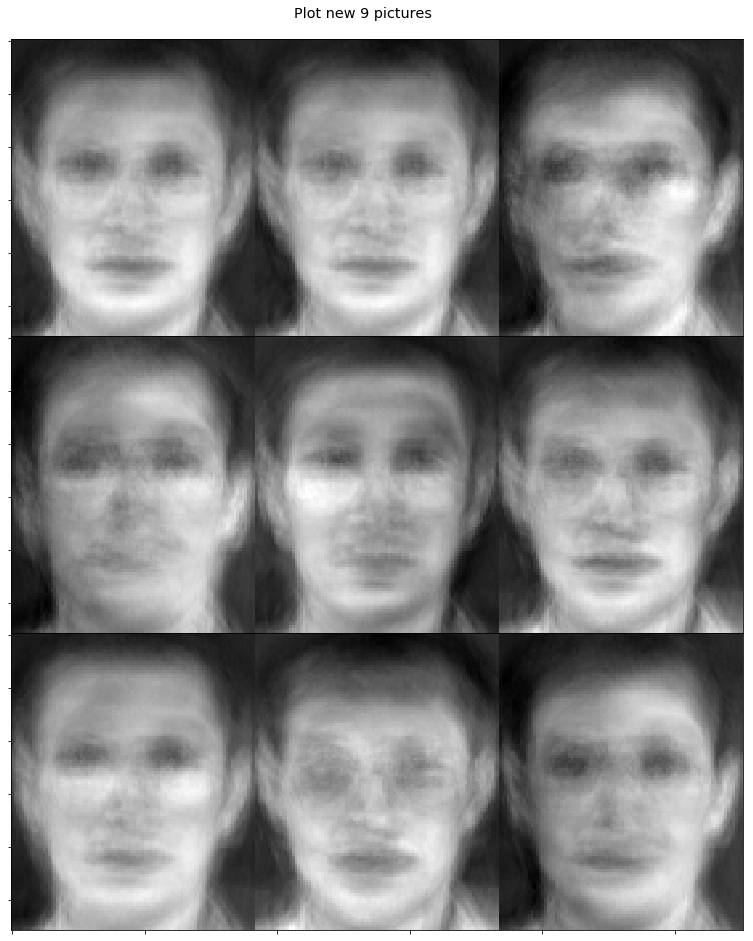

In [21]:
# plot several (randomly chosen) origial pictures and new pictures from V and NewV
NewV = W.dot(H)
nr_rows = 3
nr_cols = nr_rows
NrP = nr_rows ** 2 

idx_start = np.random.randint(0, N-NrP)

V_NrP = V[:,idx_start:idx_start+NrP].reshape((92, 112, NrP))
NewV_NrP = NewV[:,idx_start:idx_start+NrP].reshape((92, 112, NrP))
plot_img(V_NrP, nr_rows, nr_cols, 'Plot original ' + str(NrP) +' pictures')
plot_img(NewV_NrP, nr_rows, nr_cols, 'Plot new ' + str(NrP) +' pictures')


### Question 2.2 run the algorithm with different $\beta_w$ and $\beta_h$, with $K= 25, \alpha_w = \alpha_h =1$

#####  Q2.2  set the parameters for different betas

In [22]:
# set the parameters for different betas
nr_cases = 9
paras = []

beta_w = [0.3, 1, 1.7]
beta_h = [0.3, 1, 1.7]

for i in range(nr_cases): 
    para_wh = np.zeros(4)
    para_wh[0] = 1 # alpah_w = 1 
    para_wh[2] = 1 # alpah_h = 1
    beta_w_id = i // 3
    beta_h_id = i % 3
    
    para_wh[1] = beta_w[beta_w_id]
    para_wh[3] = beta_h[beta_h_id] 
    
    paras.append(para_wh)

#####  Q2.2  run EM with different betas

In [23]:
Diffs_betas = []
Ws_betas = []
Hs_betas = []

nr_iter = 150 
for i in range(nr_cases): 
    para_whi = paras[i]
    Diffs, W, H = EM(para_whi, K, nr_iter, threshold=1e-8)
    
    Diffs_betas.append(Diffs)
    ErrInfStr = 'alpha_w = ' + str(para_whi[0]) + ', beta_w = ' + str(
        para_whi[1]) + ', alpha_h = ' + str(para_whi[2]) + ', beta_h = ' + str(para_whi[3])
    print ("Case " + str(i+1) + ': ' + ErrInfStr + ',  Final Error: ' + str(np.round(Diffs[-1][0], 2)))
    Ws_betas.append(W)
    Hs_betas.append(H)

Case 1: alpha_w = 1.0, beta_w = 0.3, alpha_h = 1.0, beta_h = 0.3,  Final Error: 46551.91
Case 2: alpha_w = 1.0, beta_w = 0.3, alpha_h = 1.0, beta_h = 1.0,  Final Error: 46434.65
Case 3: alpha_w = 1.0, beta_w = 0.3, alpha_h = 1.0, beta_h = 1.7,  Final Error: 46505.39
Case 4: alpha_w = 1.0, beta_w = 1.0, alpha_h = 1.0, beta_h = 0.3,  Final Error: 47085.78
Case 5: alpha_w = 1.0, beta_w = 1.0, alpha_h = 1.0, beta_h = 1.0,  Final Error: 46528.92
Case 6: alpha_w = 1.0, beta_w = 1.0, alpha_h = 1.0, beta_h = 1.7,  Final Error: 46399.86
Case 7: alpha_w = 1.0, beta_w = 1.7, alpha_h = 1.0, beta_h = 0.3,  Final Error: 46332.02
Case 8: alpha_w = 1.0, beta_w = 1.7, alpha_h = 1.0, beta_h = 1.0,  Final Error: 46490.58
Case 9: alpha_w = 1.0, beta_w = 1.7, alpha_h = 1.0, beta_h = 1.7,  Final Error: 46614.53


##### Q 2.2  Plot the Ws for differnt beta_w and beta_h

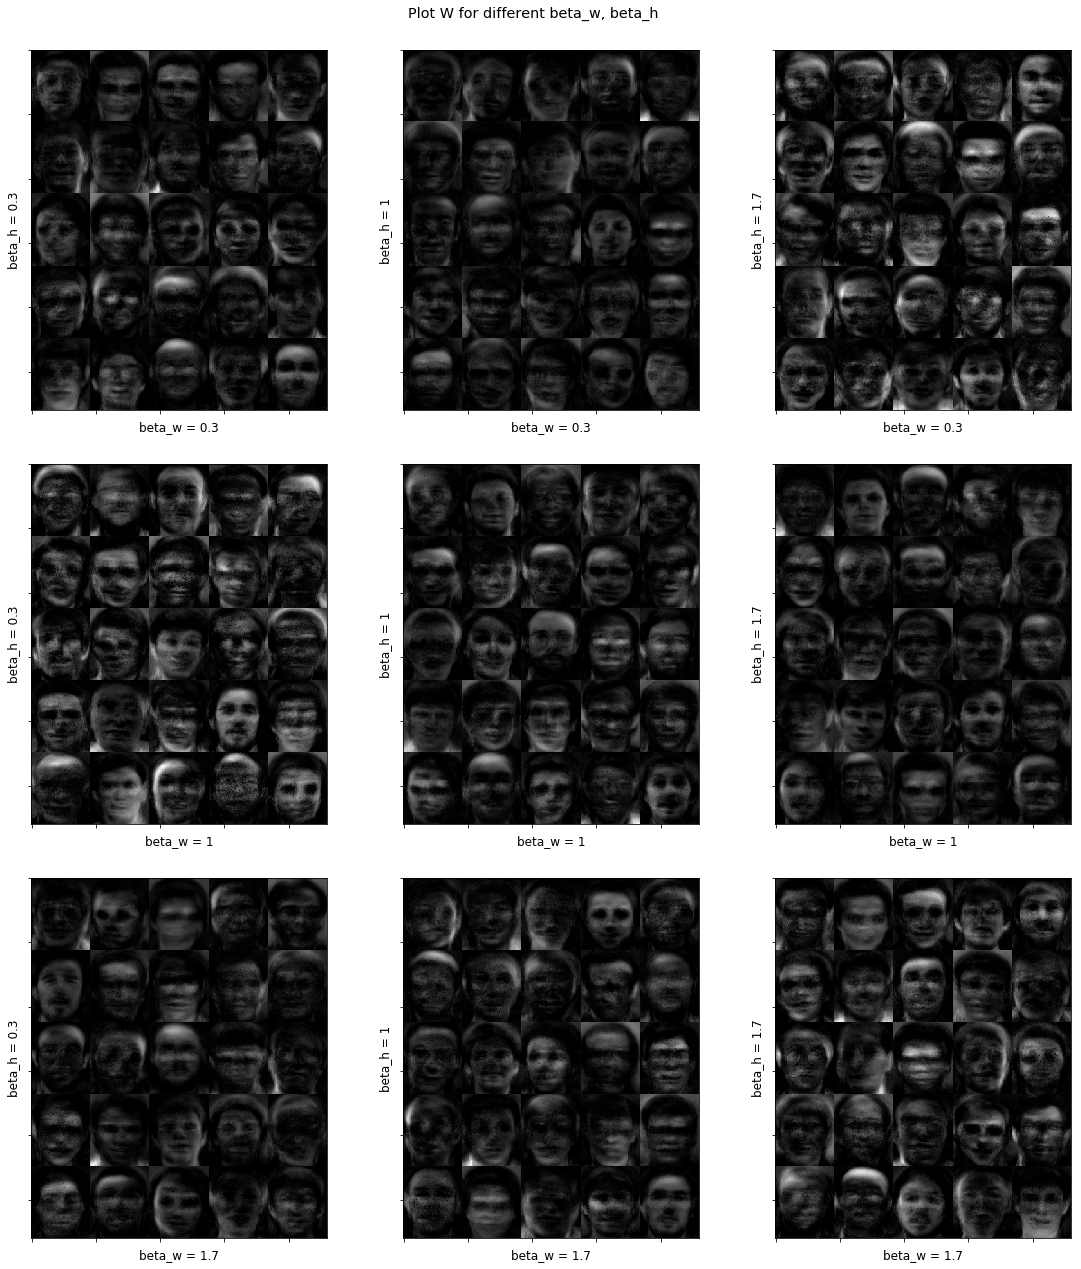

In [24]:
def transfer_W(W_s): 
    # transfer W into a form that could be plot directly
    size = np.shape(W_s) # F * K
    K = size[1]
    
    nr_rows = math.ceil(K ** 0.5)
    nr_cols = nr_rows
    
    part_nr = 0
    img_rows = []
    for rowi in np.arange(nr_rows):     
        img_row_i = []
        for colj in range(nr_cols):  
            img_j = []
            if part_nr < K:
                img_j = W_s[:,part_nr].reshape((92, 112))
            else: 
                break
            if colj > 0: 
                img_ij = np.concatenate((img_ij, img_j.T), axis=1)
            else: 
                img_ij = img_j.T
            part_nr += 1 
            
        if rowi > 0: 
            img_rows = np.concatenate((img_rows, img_ij)) 
        else: 
            img_rows = img_ij    
            
    return  img_rows       



def plot_Ws(Ws, nr_rows, nr_cols, titlestr, grayscale=True): 
    # plot the Ws generated from different parameters 
    fig = plt.figure(figsize = (20,20))    
    gs1 = gridspec.GridSpec(nr_rows, nr_cols)
    gs1.update(wspace=0, hspace=0.15) # set the spacing between axes.
    cmap = 'None' if grayscale == False else 'gray'
    img_nr = 0 
    
    for rowi in np.arange(nr_rows):         
          for colj in np.arange(nr_cols): 
            Wis = Ws[img_nr]
            beta_w_id = img_nr // nr_rows
            beta_h_id = img_nr % nr_rows
            img = transfer_W(Wis)
        
            ax1 = plt.subplot(gs1[rowi, colj])
            plt.axis('on')

            plt.imshow(img, cmap=cmap)  
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_xlabel('beta_w = ' + str(beta_w[beta_w_id]))
            ax1.set_ylabel('beta_h = ' + str(beta_h[beta_h_id]))
            ax1.set_aspect('equal')
            plt.subplots_adjust(wspace=0, hspace=0) 
        
            img_nr += 1

    fig.suptitle(titlestr)
    fig.subplots_adjust(top=0.95)
    plt.show()       

plot_Ws(Ws_betas, nr_rows=3, nr_cols=3, titlestr='Plot W for different beta_w, beta_h')   

#####  Q2.2. plot the convergence graph(error measured by Euclidean distance)

In [25]:
colors = ['b', 'g', 'r','m', 'y', 'k', 'c', 'b',  'r','m', 'y', 'k']  # up to 12 different line/color style combinations
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':',]
def plot_covergence(Diffs, titlestr): 
    
    nr_cases = len(Diffs)   
    fig = plt.figure(figsize = (10,10))    
    for i in range(nr_cases): 
        Diffi = Diffs[i]
        plt.plot(range(len(Diffi)), Diffi, label = 'Case' + str(i+1), c= colors[i], linestyle=linestyles[i])

    plt.legend()
    plt.xlabel('Number of iterations')
    plt.ylabel('Error')
    plt.title(titlestr)
    plt.show()      

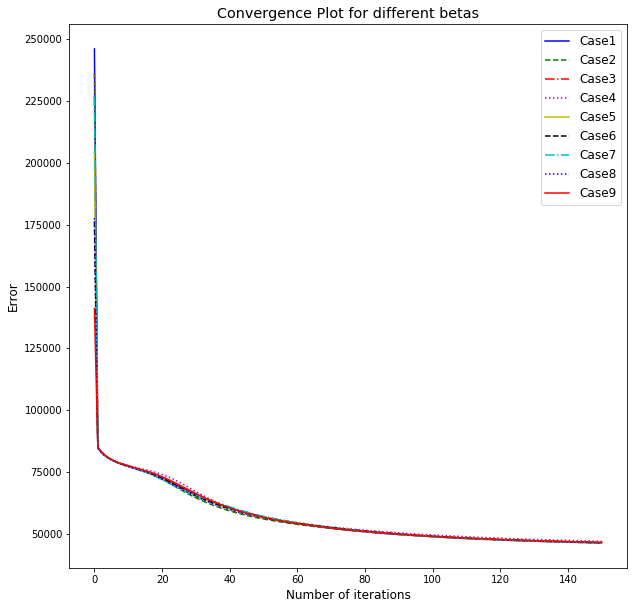

In [26]:
plot_covergence(Diffs_betas, 'Convergence Plot for different betas')

#####  Q 2.2 Comment on the parameter beta
As shown from the printed Final errors for different cases, and also the generated Ws for different cases. The beta only plays a role in the initialization stage, however with the iterations going on, the effect of differnt betas becomes almost non-distinguishable. We could conclude that we do not observe significant difference caused by the beta value.  

#### Question 2.3: different alpha for w and h

#####  Q 2.3 set the parameters for different alphas

In [27]:
# set the parameters for different alphas
nr_cases = 9
paras = []

alpha_w = [0.3, 1, 1.7]
alpha_h = [0.3, 1, 1.7]

for i in range(nr_cases): 
    para_wh = np.zeros(4)
    para_wh[1] = 1 # beta_w = 1 
    para_wh[3] = 1 # beta_h = 1
    alpha_w_id = i // 3
    alpha_h_id = i % 3
    
    para_wh[0] = alpha_w[alpha_w_id]
    para_wh[2] = alpha_h[alpha_h_id] 
    
    paras.append(para_wh)


##### Q 2.3 run the model for different alphas

In [28]:
# run the model for different alphas
Diffs_alphas = []
Ws_alphas = []
Hs_alphas = []

nr_iter = 150
for i in range(nr_cases): 
    para_whi = paras[i]
    Diffs, W, H = EM(para_whi, K, nr_iter, threshold=1e-8)
    
    Diffs_alphas.append(Diffs)
    ErrInfStr = 'alpha_w = ' + str(para_whi[0]) + ', beta_w = ' + str(
        para_whi[1]) + ', alpha_h = ' + str(para_whi[2]) + ', beta_h = ' + str(para_whi[3])
    print ("Case " + str(i+1) + ': ' + ErrInfStr + ',  Final Error: ' + str(np.round(Diffs[-1][0], 2)))
    Ws_alphas.append(W)
    Hs_alphas.append(H)

Case 1: alpha_w = 0.3, beta_w = 1.0, alpha_h = 0.3, beta_h = 1.0,  Final Error: 52273.54
Case 2: alpha_w = 0.3, beta_w = 1.0, alpha_h = 1.0, beta_h = 1.0,  Final Error: 52614.83
Case 3: alpha_w = 0.3, beta_w = 1.0, alpha_h = 1.7, beta_h = 1.0,  Final Error: 53779.29
Case 4: alpha_w = 1.0, beta_w = 1.0, alpha_h = 0.3, beta_h = 1.0,  Final Error: 49870.2
Case 5: alpha_w = 1.0, beta_w = 1.0, alpha_h = 1.0, beta_h = 1.0,  Final Error: 46634.37
Case 6: alpha_w = 1.0, beta_w = 1.0, alpha_h = 1.7, beta_h = 1.0,  Final Error: 47051.69
Case 7: alpha_w = 1.7, beta_w = 1.0, alpha_h = 0.3, beta_h = 1.0,  Final Error: 50875.94
Case 8: alpha_w = 1.7, beta_w = 1.0, alpha_h = 1.0, beta_h = 1.0,  Final Error: 46957.78
Case 9: alpha_w = 1.7, beta_w = 1.0, alpha_h = 1.7, beta_h = 1.0,  Final Error: 46019.06


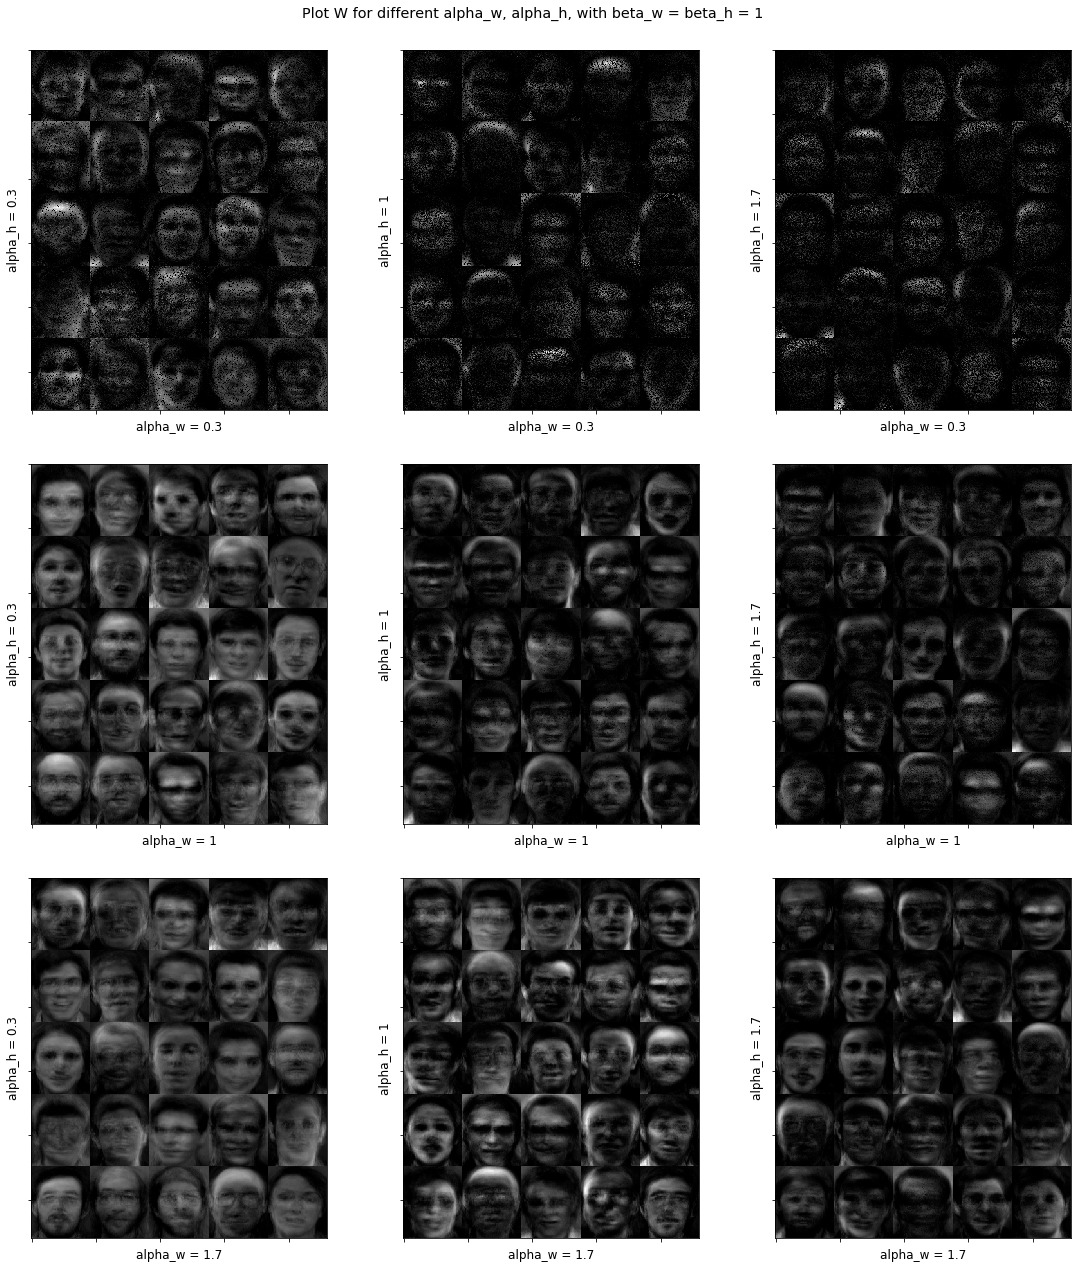

In [29]:
def plot_Ws_alphas(Ws, nr_rows, nr_cols, titlestr, grayscale=True): 
    # plot the Ws generated from different parameters 
    fig = plt.figure(figsize = (20,20))    
    gs1 = gridspec.GridSpec(nr_rows, nr_cols)
    gs1.update(wspace=0, hspace=0.15) # set the spacing between axes.
    cmap = 'None' if grayscale == False else 'gray'
    
    img_nr = 0 
    
    for rowi in np.arange(nr_rows):         
          for colj in np.arange(nr_cols): 
            Wis = Ws[img_nr]
            
            alpha_w_id = img_nr // nr_rows
            alpha_h_id = img_nr % nr_rows
            
            img = transfer_W(Wis)
        
            ax1 = plt.subplot(gs1[rowi, colj])
            plt.axis('on')

            plt.imshow(img, cmap=cmap)  
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_xlabel('alpha_w = ' + str(alpha_w[alpha_w_id]))
            ax1.set_ylabel('alpha_h = ' + str(alpha_h[alpha_h_id]))
            ax1.set_aspect('equal')
            plt.subplots_adjust(wspace=0, hspace=0) 
        
            img_nr += 1

    fig.suptitle(titlestr)
    fig.subplots_adjust(top=0.95)
    plt.show()       

plot_Ws_alphas(Ws_alphas, nr_rows=3, nr_cols=3, 
               titlestr='Plot W for different alpha_w, alpha_h, with beta_w = beta_h = 1') 

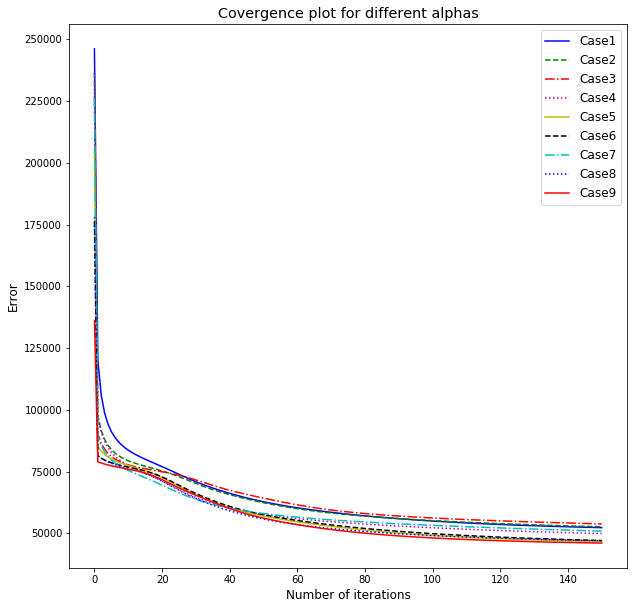

In [30]:
plot_covergence(Diffs_alphas, 'Covergence plot for different alphas')

#### Comment on different alphas

We could clearly see that when alpha is small(either alpha_w or alpha_h or both, especially when alpha_w is small), we will not get a good result. This matches with the theory background. Because when alpha is small, most of the values from Gamma distribution will be close to zero and only a few parameters will dominate. The lead to a sparse representation of the original matrix $V$. I.e, we lost some information on the initialization phase. 

And as we could see from the printed final error for different cases, we could see that when alpha value increases, the final error reduces. Among all the nine cases, the Case 9: (alpha_w = 1.7, beta_w = 1.0, alpha_h = 1.7, beta_h = 1.0) has the best performance and the largest alphas. 



#### Question 2.4: different K with  alpha_w = alpha_h = beta_w = beta_h = 1

##### Q 2.4 initilize the parameters for different Ks

In [31]:
# initilize the parameters
Ks = [2**2, 3**2, 4 **2, 5**2, 6**2, 7**2] # for display convinenece, K is take to be n ** 2, n = 2, 3, ...
nr_cases = len(Ks)

para_wh = [1, 1, 1, 1]

Diffs_Ks = []
Ws_Ks = []
Hs_Ks = []


nr_iter = 150
for i in range(nr_cases): 
    Diffs, W, H = EM(para_wh, Ks[i], nr_iter, threshold=1e-8)
    
    Diffs_Ks.append(Diffs)
    print ("Case " + str(i+1) + ': ' + ' with K = ' + str(Ks[i]) + ',  Final Error: ' + str(np.round(Diffs[-1][0], 2)))
    Ws_Ks.append(W)
    Hs_Ks.append(H)
    
    

Case 1:  with K = 4,  Final Error: 62249.54
Case 2:  with K = 9,  Final Error: 54392.44
Case 3:  with K = 16,  Final Error: 49546.09
Case 4:  with K = 25,  Final Error: 46592.13
Case 5:  with K = 36,  Final Error: 44111.5
Case 6:  with K = 49,  Final Error: 42183.73


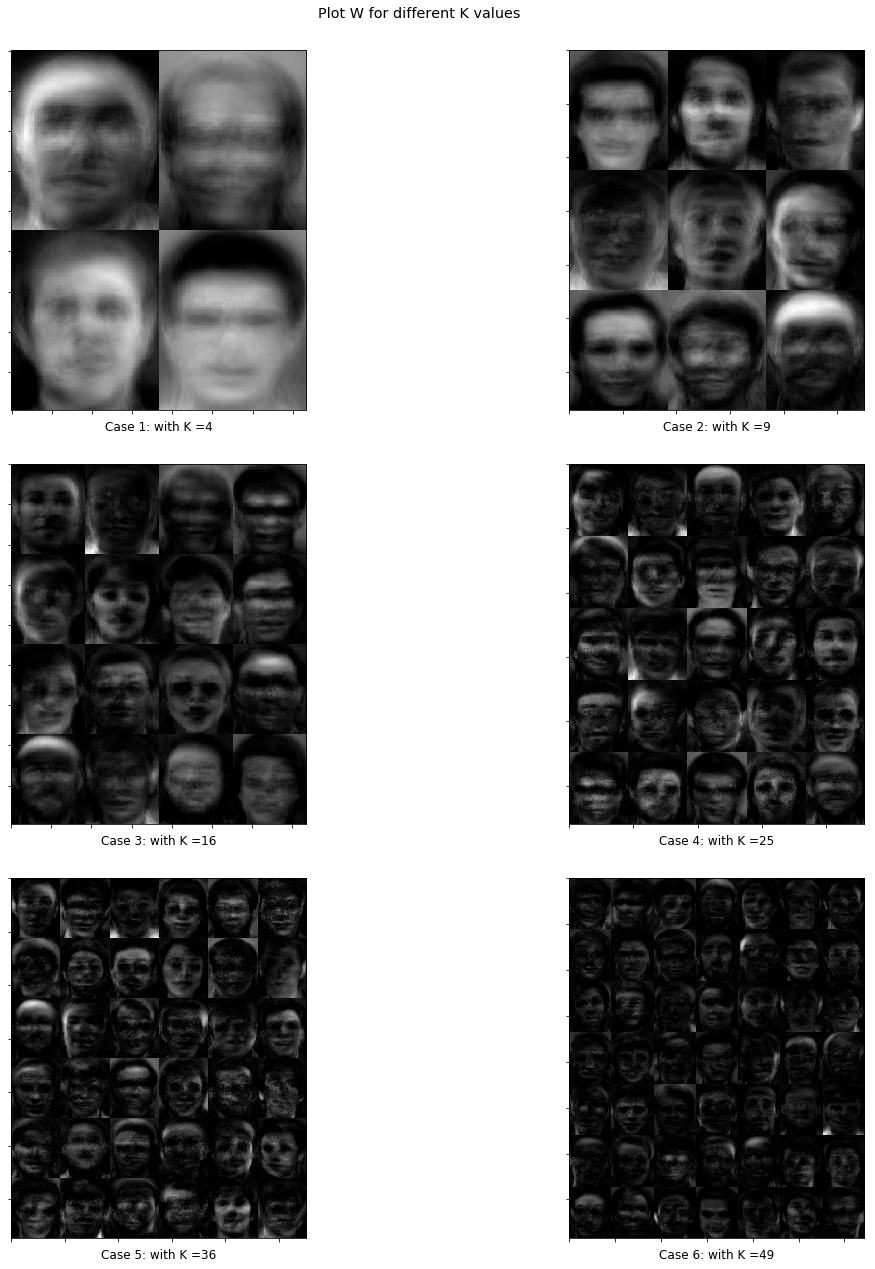

In [34]:
def plot_Ws_Ks(Ws, nr_rows, nr_cols, titlestr, grayscale=True): 
    # plot the Ws generated from different parameters 
    fig = plt.figure(figsize = (20,20))    
    gs1 = gridspec.GridSpec(nr_rows, nr_cols)
    gs1.update(wspace=0, hspace=0.15) # set the spacing between axes.
    cmap = 'None' if grayscale == False else 'gray'
    
    img_nr = 0 
    
    for rowi in np.arange(nr_rows):         
          for colj in np.arange(nr_cols): 
            Wis = Ws[img_nr]
            Ki = Ks[img_nr]
            
            img = transfer_W(Wis)
        
            ax1 = plt.subplot(gs1[rowi, colj])
            plt.axis('on')

            plt.imshow(img, cmap=cmap)  
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_xlabel('Case ' + str(img_nr + 1) + ": with K =" + str(Ki) )
            ax1.set_aspect('equal')
            plt.subplots_adjust(wspace=0, hspace=0) 
        
            img_nr += 1

    fig.suptitle(titlestr)
    fig.subplots_adjust(top=0.95)
    plt.show()       

plot_Ws_Ks(Ws_Ks, nr_rows=3, nr_cols=2, 
               titlestr='Plot W for different K values') 

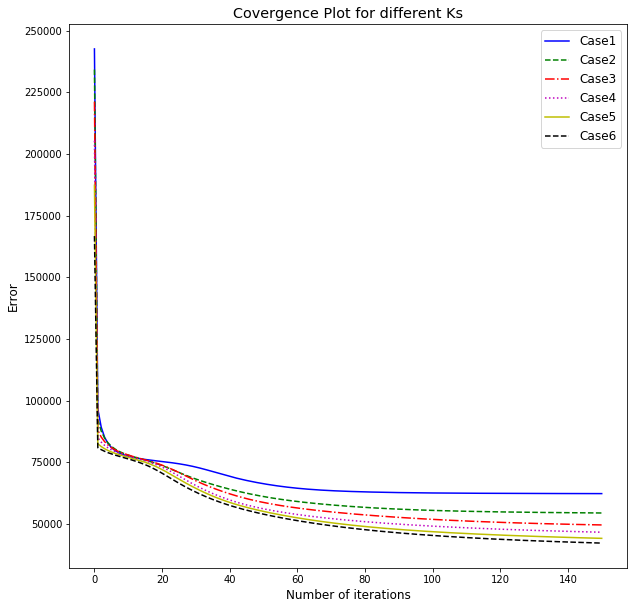

In [33]:
plot_covergence(Diffs_Ks, 'Covergence Plot for different Ks')    

#### Comment on different Ks 

We could see that with high K values, the error becomes much smaller, and more information is preserved by the W. But the difference is not that significant, which means the most distinguishable features of the face only exist in a small part of the face, that is saying when K is large enough, increasing K will no longer reduce the approximation error as fast as when K is small. 